In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from netCDF4 import Dataset
import utils as utl

In [2]:
Nh = 96
Nt = 37
sspacing = 3
tspacing = 4

HTLS_sknots = np.arange(0,Nh,sspacing)
HTHS_sknots = np.arange(0,Nh,1)
LTHS_tknots = np.arange(0,Nh,tspacing)
Nl = len(HTLS_sknots)
Ns = len(LTHS_tknots)

Np = 3 # haft number of predictor
Dh = (sspacing+1)*(sspacing+1) # dimension of the HR vector to reconstruct
Dl = (2*Np+1)*(2*Np+1) # number of LR predictors

N = Nt*Ns

[]

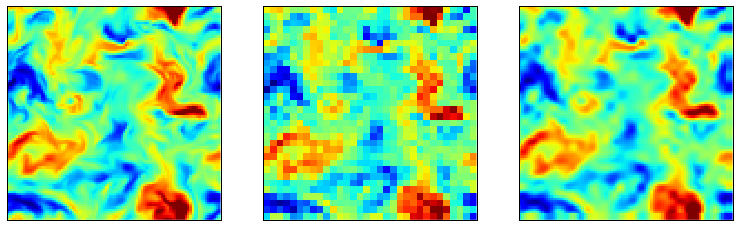

In [3]:
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
x_HR_ref = np.array(ncfile1.variables['velocity_x'][0,0:Nh,0:Nh,0])
ncfile1.close()
x_LR = x_HR_ref[0:-1:sspacing,0:-1:sspacing]
x_interp = utl.interp2(HTLS_sknots, HTLS_sknots, x_LR, HTHS_sknots, HTHS_sknots)

fig = plt.figure(figsize=(13, 5))

ax = plt.subplot(1,3, 1)
cax = plt.imshow(x_HR_ref, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())
    
ax = plt.subplot(1,3, 2)
cax = plt.imshow(x_LR, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,3, 3)
cax = plt.imshow(x_interp, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

In [4]:
zz_HR, yy_HR, zz_LR, yy_LR = utl.gen_grids(sspacing, sspacing, Nh, Np) 
patches_HR = x_HR_ref[yy_HR,zz_HR]
patches_LR = x_HR_ref[yy_LR,zz_LR]

Xh_tr = np.zeros((Nt*Ns*Nl*Nl, Dh))
Xl_tr = np.zeros((Nt*Ns*Nl*Nl, Dl))
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')

for t in range(Nt):
    count = 0
    for i in LTHS_tknots:
        xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
        patches_HR = xh[yy_HR,zz_HR]
        patches_LR = xh[yy_LR,zz_LR]
        Xh_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_HR,(Nl*Nl, Dh))
        Xl_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_LR,(Nl*Nl, Dl)) 
        # reshape will take from last index toward first one
        count = count + 1
ncfile1.close()

# normalized: centered, variance 1
mea_l = np.zeros(Dl)
sig_l = np.zeros(Dl)
for k in range(Dl):
    mea_l[k] = np.mean(Xl_tr[:,k])
    sig_l[k] = np.std(Xl_tr[:,k])
    Xl_tr[:,k] = (Xl_tr[:,k]-mea_l[k])/sig_l[k]


mea_h = np.zeros(Dh)
sig_h = np.zeros(Dh)
for k in range(Dh):
    mea_h[k] = np.mean(Xh_tr[:,k])
    sig_h[k] = np.std(Xh_tr[:,k])
    Xh_tr[:,k] = (Xh_tr[:,k]-mea_h[k])/sig_h[k]   
 

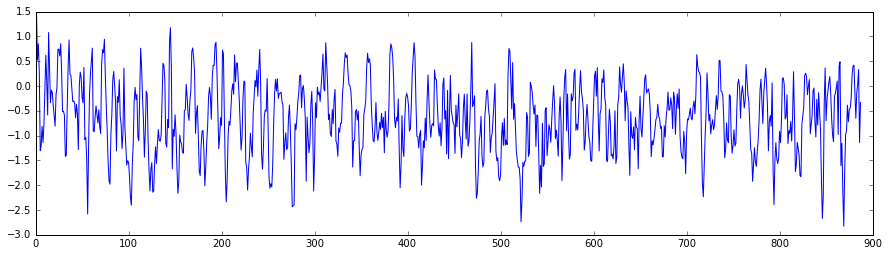

In [5]:
fig = plt.figure(figsize=(15, 4))
ax=plt.plot(Xh_tr[1:-1:Nl*Nl,1])

In [6]:
from sklearn import linear_model
n_alphas = 20
alphas = np.append([],np.logspace(1, 7, n_alphas))

clf = linear_model.Ridge( fit_intercept=False, normalize=False)
coefs_RR = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(Xl_tr[:,:], Xh_tr[:,:])
    coefs_RR.append(clf.coef_)  

/home/nguyen/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


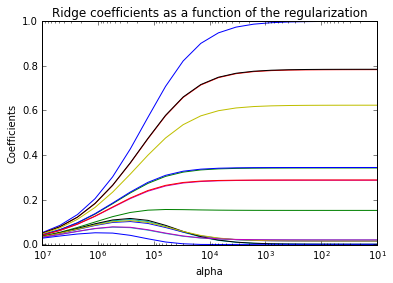

In [7]:
coefs_part = [coefs_RR[i][:,24] for i in range (n_alphas)]
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm', 'b'])

ax.plot(alphas, coefs_part)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [8]:
print np.shape(coefs_RR)

(20, 16, 49)


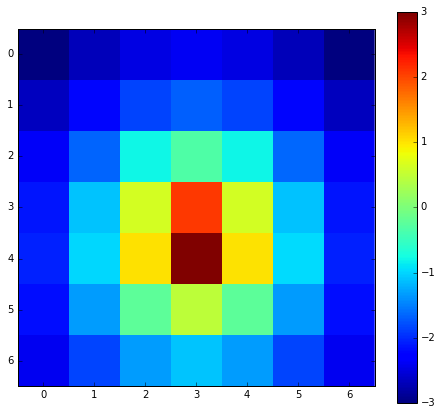

In [9]:
fig = plt.figure(figsize=(8, 7))
plt.imshow(np.reshape(coefs_RR[-1][8,:],((2*Np+1),(2*Np+1))),interpolation='none')
cbar = fig.colorbar(cax, ticks=[-3, -2, -1, 0, 1, 2, 3])

### Cross-Validation curve

In [10]:
from sklearn.linear_model import Ridge
from sklearn.learning_curve import validation_curve

N_tr=10000
param_range= np.append(0, np.logspace(0, 7, 21))
train_scores, test_scores = validation_curve(Ridge(),Xl_tr[0:N_tr,:], Xh_tr[0:N_tr,:], 
                                             param_name="alpha", param_range=param_range, cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

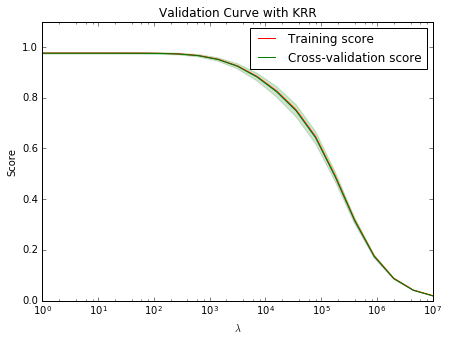

In [11]:
plt.figure(figsize=(7, 5))
plt.title("Validation Curve with KRR")
plt.xlabel("$\lambda$")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

### Cross validation

In [19]:
from sklearn.linear_model import RidgeCV
param_range= np.append(0, np.logspace(0, 7, 24))
N_tr=10000
estimator = RidgeCV(alphas=param_range, fit_intercept=False, normalize=False, cv=10)
estimator.fit(Xl_tr[0:N_tr,:], Xh_tr[0:N_tr,:])

print estimator.alphas
print estimator.alpha_

[  0.00000000e+00   1.00000000e+00   2.01533769e+00   4.06158599e+00
   8.18546731e+00   1.64964807e+01   3.32459793e+01   6.70018750e+01
   1.35031404e+02   2.72133877e+02   5.48441658e+02   1.10529514e+03
   2.22754295e+03   4.48925126e+03   9.04735724e+03   1.82334800e+04
   3.67466194e+04   7.40568469e+04   1.49249555e+05   3.00788252e+05
   6.06189899e+05   1.22167735e+06   2.46209240e+06   4.96194760e+06
   1.00000000e+07]
2.01533768594


## Learning curves

In [13]:
from sklearn import linear_model
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation

# Nlc = np.shape(Xl_tr)[0]
Nlc = 10000
cv = cross_validation.ShuffleSplit(Nlc, n_iter=20, test_size=0.2, random_state=0)

train_sizes, train_scores, test_scores = learning_curve(estimator, Xl_tr, Xh_tr, cv=cv, 
                                                            n_jobs=4, train_sizes=np.linspace(.05, 1.0, 10))

In [14]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print train_sizes
print np.shape(Xh_tr)
print np.linspace(.3, 1.0, 7)

[ 400 1244 2088 2933 3777 4622 5466 6311 7155 8000]
(909312, 16)
[ 0.3         0.41666667  0.53333333  0.65        0.76666667  0.88333333
  1.        ]


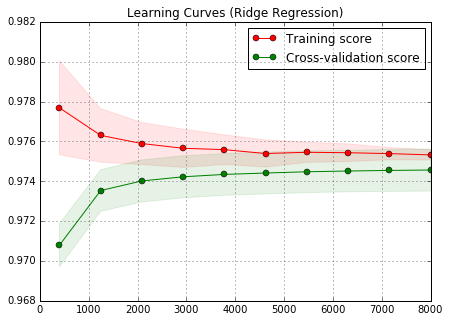

In [15]:
plt.figure(figsize=(7, 5))
plt.title("Learning Curves (Ridge Regression)")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.grid()
plt.legend(loc="best")

plt.show()